In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
%cd drive/'My Drive'/'Colab Notebooks'/
%ls

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/'
/content/drive/My Drive/Colab Notebooks
EDA.ipynb        equipment_C.csv   sample_submit.csv  track_C.csv
equipment_A.csv  equipment_D.csv   track_A.csv        track_D.csv
equipment_B.csv  index_master.csv  track_B.csv


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
%%time
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("track_" + no + ".csv", parse_dates=["date"])

CPU times: user 53 s, sys: 5.95 s, total: 59 s
Wall time: 1min


In [20]:
%%time
equipments={}
for no in ['A','B','C','D']:
    equipments[no] = pd.read_csv("equipment_" + no + ".csv")

CPU times: user 83.4 ms, sys: 7.6 ms, total: 91 ms
Wall time: 102 ms


In [0]:
from datetime import date
import datetime

In [0]:
from tqdm import tqdm

In [26]:
%%time
for no in tqdm(['A','B','C','D']):
    track = tracks[no]
    track['day'] = [(date - datetime.datetime(2017, 4, 1)).days
                    for date in track['date']]

100%|██████████| 4/4 [11:52<00:00, 172.27s/it]

CPU times: user 11min 45s, sys: 7.12 s, total: 11min 52s
Wall time: 11min 52s


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
def linear_plot(data, target):
    X = data.loc[data[target].notnull(), 'day'].values
    X = X.reshape(len(X), 1)
    y = data[target].dropna().values

    clf = LinearRegression()
    clf.fit(X, y)

    plt.plot(X, y, marker=".", linewidth=0)
    plt.plot(X, clf.predict(X))

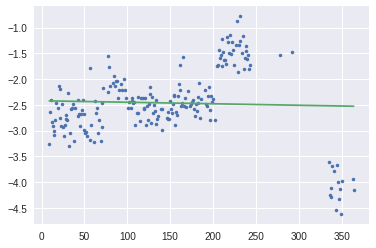

In [52]:
data = track[track["キロ程"]==22809]
target = '高低左'
linear_plot(data, target)

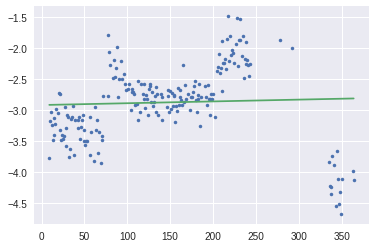

In [53]:
data = track[track["キロ程"]==22809]
target = '高低右'
linear_plot(data, target)

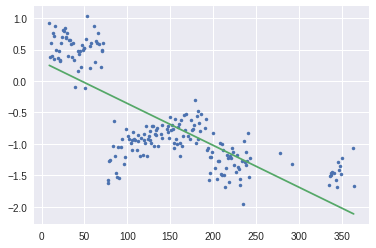

In [54]:
data = track[track["キロ程"]==22809]
target = '通り左'
linear_plot(data, target)

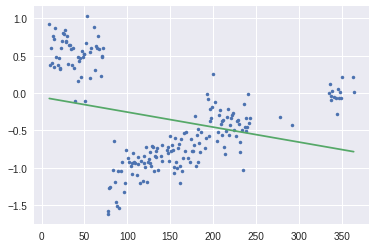

In [55]:
data = track[track["キロ程"]==22809]
target = '通り右'
linear_plot(data, target)

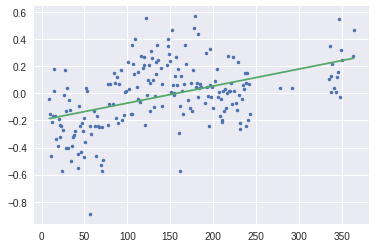

In [56]:
data = track[track["キロ程"]==22809]
target = '水準'
linear_plot(data, target)

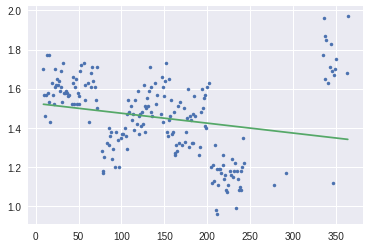

In [58]:
data = track[track["キロ程"]==22809]
target = '軌間'
linear_plot(data, target)

In [0]:
corr = track.drop(['date', 'キロ程'], axis=1)
corr['高低左-高低右'] = corr['高低左'] - corr['高低右']
corr['通り左-通り右'] = corr['通り左'] - corr['通り右']

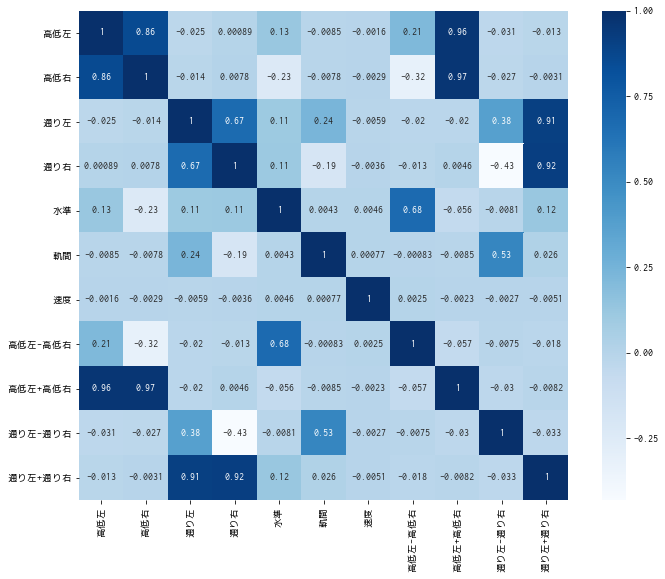

In [0]:
plt.figure(figsize=(12, 9))
sns.heatmap(corr.corr(), annot=True, square=True, cmap='Blues')

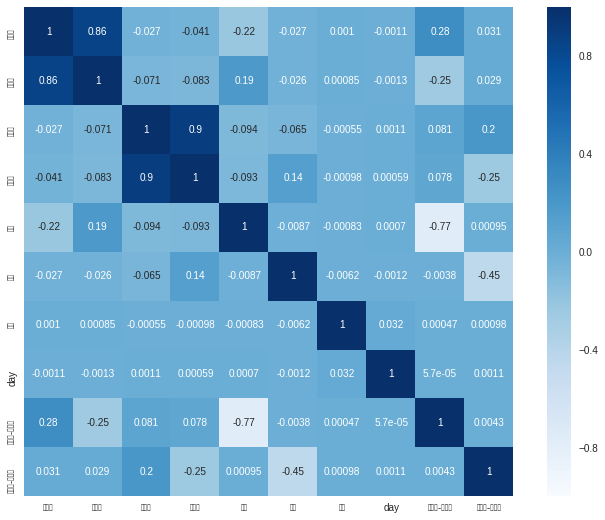

In [60]:
plt.figure(figsize=(12, 9))
sns.heatmap(corr.corr(), annot=True, square=True, cmap='Blues')

In [61]:
corr.corr()['高低左']

高低左        1.000000
高低右        0.859097
通り左       -0.027413
通り右       -0.040975
水準        -0.222149
軌間        -0.027458
速度         0.001034
day       -0.001142
高低左-高低右    0.279117
通り左-通り右    0.030803
Name: 高低左, dtype: float64

In [62]:
corr.corr()['水準']

高低左       -0.222149
高低右        0.185463
通り左       -0.094029
通り右       -0.093476
水準         1.000000
軌間        -0.008710
速度        -0.000831
day        0.000695
高低左-高低右   -0.768035
通り左-通り右    0.000955
Name: 水準, dtype: float64

In [0]:
from sklearn import svm

In [64]:
clf = svm.OneClassSVM(nu=0.05, kernel='rbf', gamma=0.0001)
X = track[track["キロ程"]==22809]["高低左"].dropna()
X = X.reshape([len(X), 1])
clf.fit(X)
y_pred = clf.predict(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
print(sum(y_pred == 1), sum(y_pred == -1))

193 12


In [0]:
check_outlier = pd.DataFrame(track[track["キロ程"]==22809]["高低左"].dropna())
check_outlier['out'] = y_pred

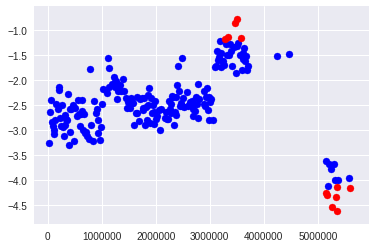

In [67]:
plt.scatter(check_outlier[check_outlier['out'] == 1].index, check_outlier.loc[check_outlier['out'] == 1, '高低左'], c='b')
plt.scatter(check_outlier[check_outlier['out'] == -1].index, check_outlier.loc[check_outlier['out'] == -1, '高低左'], c='r')

In [0]:
data = track[track["キロ程"]==22809]
target = '高低左'
linear_plot(data, target)

In [0]:
import math

In [0]:
def get_slope(days, koutei):
    kilos =  track['キロ程'].unique()
    slopes = []
    clf = LinearRegression()
    for kilo in tqdm(kilos):
        target = [i  for i in range(len(track)) if track.loc[i, "キロ程"] == kilo and not math.isnan(track.loc[i, '高低左'])]
        X = track.loc[target, 'day'].values
        X = X.reshape(len(X), 1)
        y = track.loc[target, '高低左'].values

        clf.fit(X, y)
        slope = clf.coef_[0]
        slopes.append(slope)

    return slopes

In [124]:
summarys = pd.DataFrame()
for no in tqdm(['A','B','C','D']):
    track = tracks[no][:100000]
    equipment = equipments[no]
    
    summary = pd.DataFrame(columns=['キロ程', 'rosen', 'slope'])
    summary['キロ程'] = track['キロ程'].unique()
    summary['rosen'] = no
    kilos =  track['キロ程'].unique()
    for kilo in kilos:
        
    days = track['days']
    koutei = track['高低左']
    summary['slope'] = get_slope(days, koutei)

    describe = track.groupby('キロ程').describe()
    cols = []
    for col in describe.columns:
        cols.append(col[0] + '_' + col[1])
    describe.columns = cols
    describe = describe.reset_index(drop=True)

    summary = pd.concat([summary, describe, equipment.drop('キロ程', axis=1)], axis=1)

    summarys = pd.concat([summarys, summary], axis=0)






  0%|          | 0/4 [00:00<?, ?it/s]





  0%|          | 0/27906 [00:00<?, ?it/s]





  0%|          | 1/27906 [00:00<6:38:17,  1.17it/s]





  0%|          | 2/27906 [00:01<6:35:23,  1.18it/s]





  0%|          | 3/27906 [00:02<6:34:43,  1.18it/s]





  0%|          | 4/27906 [00:03<6:38:07,  1.17it/s]





  0%|          | 5/27906 [00:04<6:39:20,  1.16it/s]





  0%|          | 6/27906 [00:05<6:41:04,  1.16it/s]





  0%|          | 7/27906 [00:06<6:42:35,  1.15it/s]





  0%|          | 8/27906 [00:06<6:44:07,  1.15it/s]

KeyboardInterrupt: ignored

In [90]:
kilos

,キロ程,rosen,slope,day_count,day_mean,day_std,day_min,day_25%,day_50%,day_75%,...,高低左_75%,高低左_max,バラスト,ロングレール,マクラギ種別,橋りょう,踏切,通トン,曲線半径,フラグ
0,10000.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,-1.16,-1.16,1,1,3,0,0,13.607,0,1
1,10001.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,-1.17,-1.17,1,1,3,0,0,13.607,0,1
2,10002.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,-1.09,-1.09,1,1,3,0,0,13.607,0,1
3,10003.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,-0.64,-0.64,1,1,3,0,0,13.607,0,1
4,10004.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,0.47,0.47,1,1,1,0,0,13.607,0,1
5,10005.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,2.10,2.10,1,1,1,0,0,13.607,0,1
6,10006.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,3.61,3.61,1,1,1,0,0,13.607,0,1
7,10007.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,4.05,4.05,1,1,1,0,0,13.607,0,1
8,10008.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,2.71,2.71,1,1,1,0,0,13.607,0,1
9,10009.0,A,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,...,-0.29,-0.29,1,1,1,0,0,13.607,0,1


In [0]:
for i in ['バラスト', 'フラグ', 'マクラギ種別', 'ロングレール', '踏切', '橋りょう']:
    print(kilos.groupby(i).mean()['高低左_mean'])

バラスト
0    0.133318
1   -0.020616
Name: 高低左_mean, dtype: float64
フラグ
0   -0.001233
1    0.001633
Name: 高低左_mean, dtype: float64
マクラギ種別
1   -0.025974
2    0.251909
3    0.135527
5    0.391544
6    0.754793
7    5.857316
8    0.276320
Name: 高低左_mean, dtype: float64
ロングレール
0   -0.001335
1   -0.000857
Name: 高低左_mean, dtype: float64
踏切
0   -0.010291
1    1.744016
Name: 高低左_mean, dtype: float64
橋りょう
0   -0.021332
1    0.448034
Name: 高低左_mean, dtype: float64


In [0]:
for i in ['バラスト', 'フラグ', 'マクラギ種別', 'ロングレール', '踏切', '橋りょう']:
    print(kilos.groupby(i).mean()['高低左_std'])

バラスト
0    0.927401
1    0.641795
Name: 高低左_std, dtype: float64
フラグ
0    0.619141
1    1.269833
Name: 高低左_std, dtype: float64
マクラギ種別
1    0.654929
2    0.905143
3    1.634061
5    0.594109
6    2.049579
7    0.449875
8    0.811244
Name: 高低左_std, dtype: float64
ロングレール
0    0.916646
1    0.607103
Name: 高低左_std, dtype: float64
踏切
0    0.674836
1    1.310046
Name: 高低左_std, dtype: float64
橋りょう
0    0.679906
1    0.641087
Name: 高低左_std, dtype: float64
